## Initial Work on Constrainted Version
---

In [1]:
import os, sys, json
import pickle as pkl
import pandas as pd

from rdsutils import datagen
import rdsutils.plot as rdsplot
from rdsutils.lightgbm_helpers import train_lgb_baseline_grouped
from utils import preprocess

%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings(action='ignore')

In [2]:
modeling_df = pd.read_parquet('../../artifacts/final/modeling_df_w_preds.parquet')
test_df = pd.read_parquet('../../artifacts/final/test_df_w_preds.parquet')
modeling_df.shape, test_df.shape

((112599, 241), (152951, 241))

In [3]:
# # should have been processed in previous iterations
modeling_df = preprocess(modeling_df)
test_df = preprocess(test_df)

In [4]:
seed = 12345
target_col = 'ach_target'
pred_col = 'ach_cstr_pred'

In [5]:
display(modeling_df[target_col].value_counts(), 
        test_df[target_col].value_counts())

False    108825
True       3774
Name: ach_target, dtype: int64

False    145410
True       7541
Name: ach_target, dtype: int64

### Features and Parameters

In [6]:
with open('../../models/ach-model.pkl', 'rb') as f:
    model = pkl.load(f)

In [7]:
params = model.get_params()
features = model.feature_name_

In [8]:
# pos, neg, indet, corrs = [], [], [], []
# for f in features:
#     corr = modeling_df[[f, target_col]].corr().iloc[0,1]
#     print(f'{f}: {corr}')
#     if corr < -0.:
#         neg.append(f)
#     elif corr > 0.:
#         pos.append(f)
#     else:
#         indet.append(f)
#     corrs.append(f)

In [9]:
pos = ['email_risk_score', 'fraud_score_1', 'phone_risk_score', 'fraud_score_2', 'address_risk_score']
pos_candidates = ['deposits_ratio', 'nr_transactions_per_day', 'total_outstanding_balance', 'rolling_trns_as_pct_of_bal', 
                  'sum_deposits_10d', 'max_deposits_10d_div_mean_account_balance_30d', 'nr_transactions_30d_div_nr_past_transactions']
neg = ['vantage_score', 'fico_score', 'bcc7120', 'nr_past_deposits']
neg_candidates = ['first_deposit_amount', 'mean_deposits_10d_div_mean_deposits', 'credit_card_loan_amount',
                  'quovo_available_bal', 'plaid_max_avail_bal', 'quovo_min_avail_bal', 'quovo_largest_checking_or_savings_balance',
                  'total_tradelines_open', 'plaid_min_avail_bal', 'plaid_days_since_first_link']
pos = pos + pos_candidates
neg = neg + neg_candidates

In [10]:
len(pos), len(neg)

(12, 14)

In [11]:

def get_monotone_constraints(features, pos, neg):
    result = []
    for f in features:
        if f in pos:
            result.append(1)
        elif f in neg:
            result.append(-1)
        else:
            result.append(0)
    return result

# manual
# params['monotone_constraints'] = get_monotone_constraints(features, pos+pos_candidates, neg+neg_candidates)
params['monotone_constraints'] = get_monotone_constraints(features, pos, neg)
params['mc_method'] = 'advanced'
params['silent'] = None
params['seed_value'] = None

#### OOS

In [12]:
pred, fimp, models, auc = train_lgb_baseline_grouped(modeling_df, features, 
                                                     params, target_col, seed=seed)
# evaluate on modeling_df
modeling_df[pred_col] = pred

[LightGBM] [Warning] Unknown parameter: importance_type
[LightGBM] [Warning] num_threads is set=16, n_jobs=-1 will be ignored. Current value: num_threads=16
[LightGBM] [Warning] lambda_l1 is set=30.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=30.0
[LightGBM] [Warning] min_data_in_leaf is set=121, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=121
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=50.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=50.0
[LightGBM] [Warning] Unknown parameter: importance_type
[LightGBM] [Warning] num_threads is set=16, n_jobs=-1 will be ignored. Current value: num_threads=16
[LightGBM] [Warning] lambda_l1 is set=30.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=30.0
[LightGBM] [Wa

#### OOT

In [13]:
import lightgbm as lgb 

clf = lgb.LGBMClassifier(**params)
X = modeling_df[features]
y = modeling_df[target_col]
clf.fit(X, y)

[LightGBM] [Warning] num_iterations is set=215, num_boost_round=215 will be ignored. Current value: num_iterations=215
[LightGBM] [Warning] lambda_l1 is set=30.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=30.0
[LightGBM] [Warning] num_threads is set=16, n_jobs=-1 will be ignored. Current value: num_threads=16
[LightGBM] [Warning] lambda_l2 is set=50.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=50.0
[LightGBM] [Warning] min_data_in_leaf is set=121, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=121
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8


LGBMClassifier(boost_from_average='false', boosting='gbdt',
               early_stopping_round=None, feature_fraction=0.8, lambda_l1=30.0,
               lambda_l2=50.0, max_depth=5, mc_method='advanced', metric='auc',
               min_data_in_leaf=121,
               monotone_constraints=[-1, -1, -1, -1, -1, -1, -1, 1, -1, 1, 1,
                                     -1, 1, -1, 1, 1, 1, -1, 1, 1, 1, -1, 1, -1,
                                     -1, 1],
               num_boost_round=215, num_leaves=52, num_threads=16,
               objective='binary', scale_pos_weight=28.835453100158983,
               seed=12345, seed_value=None, silent=None, tree_learner='feature',
               two_round=True, verbose=-1)

In [14]:
# get OOT preds
test_df[pred_col] = clf.predict_proba(test_df[features])[:,1]

In [15]:
final_model = clf

### Comparsion
---

In [16]:
import scikitplot as skplt
import matplotlib.pyplot as plt
from rdsutils.plot import plot_auc_curve_mult, plot_pr_curve_mult, plot_feature_over_time

plt.style.use('seaborn')

def get_binary_metrics(y_true, y_pred):
    from sklearn.metrics import roc_auc_score, average_precision_score
    from scikitplot.helpers import binary_ks_curve
    
    auc = round(roc_auc_score(y_true=y_true,
                              y_score=y_pred)*100, 2)
    ap = round(average_precision_score(y_true=y_true,
                                       y_score=y_pred)*100, 2)
    _, _, _, ks, _, _ = binary_ks_curve(y_true=y_true, y_probas=y_pred)
    ks = round(ks*100, 2) 
    
    metrics = {'auc': auc,
               'ap': ap,
               'ks': ks}

    return metrics


def get_pred_reports(df, target_col, pred_cols):
    import pandas as pd
    result = {}
    for col in pred_cols:
        metrics = get_binary_metrics(df[target_col], df[col])
        result[col] = metrics
    return pd.DataFrame(result).T

In [17]:
print('OOS')
metrics = get_pred_reports(modeling_df, target_col, 
                           ['deposit_v1_pred', 
                            'customer_pred',
                            'ach_pred_cleaned', 
                            pred_col])
display(metrics)

print('OOT')
metrics = get_pred_reports(test_df, target_col, 
                           ['deposit_v1_pred', 
                            'customer_pred',
                            'ach_pred_cleaned', 
                            pred_col])
display(metrics)

OOS


,auc,ap,ks
deposit_v1_pred,85.06,27.62,56.89
customer_pred,89.19,51.03,65.33
ach_pred_cleaned,92.77,66.28,72.55
ach_cstr_pred,92.38,61.79,71.29


OOT


,auc,ap,ks
deposit_v1_pred,83.61,29.14,53.76
customer_pred,88.94,49.57,63.28
ach_pred_cleaned,93.19,67.07,72.49
ach_cstr_pred,92.60,62.82,70.80


#### Plotting

In [18]:
def plot_pr_curve_mult(y_test, y_scores, title=None, 
                       colors=['b'], figsize=None,
                       ax=None, fig=None, **kwargs):
    """Plot multiple precision-recall curves on the same canvas.
    
    Parameters
    ----------
    y_test : pd.Series, np.ndarray - shape [n]
        Targets.
    y_scores: [(y_score, label), ...]
        list of tuples with y_score and corresponding label
        y_score - pd.Series
        label - str - label to show in legend
    title: str
        title for the plot
    colors: list(str)
        list of colors for the y_scores respectively
    figsize: tuple(int)
        figure size for plt
    
        
    Returns
    -------
    fig:
        matplotlib figure
    ax:
        matplotlib axis
    """
    assert(len(y_scores) == len(colors))
    from sklearn.metrics import average_precision_score
    from sklearn.metrics import precision_recall_curve
    import matplotlib.pyplot as plt
    
    aps = []
    if ax is None:
        fig, ax = plt.subplots(figsize=figsize)
            
    for i in range(len(y_scores)):
        y_score, label = y_scores[i]
        
        average_precision = average_precision_score(y_test, y_score)
        aps.append(average_precision)
        precision, recall, _ = precision_recall_curve(y_test, y_score, **kwargs)

        ax.step(recall, precision, color=colors[i], alpha=0.2,
                 where='post', label=label)
        ax.fill_between(recall, precision, alpha=0.2, color=colors[i])
    
    ax.legend()

    ax.set_xlabel('Recall')
    ax.set_ylabel('Precision')
    ax.set_ylim([0.0, 1.05])
    ax.set_xlim([0.0, 1.0])
    ax.set_title(title)
    
    return fig, ax

def plot_auc_curve_mult(y_test, y_scores, title, 
                        colors=['b'], figsize=None,
                        ax=None, fig=None, **kwargs):
    """Plot multiple AUC-ROC curves on the same canvas.
    
    Parameters
    ----------
    y_test : pd.Series, np.ndarray - shape [n]
        Targets.
    y_scores: [(y_score, label), ...]
        list of tuples with y_score and corresponding label
        y_score - pd.Series
        label - str - label to show in legend
    title: str
        title for the plot
    colors: list(str)
        list of colors for the y_scores respectively
    figsize: tuple(int)
        figure size for plt
    
        
    Returns
    -------
    fig:
        matplotlib figure
    ax:
        matplotlib axis
    """
    assert(len(y_scores) == len(colors))
    from sklearn.metrics import roc_curve, roc_auc_score
    import matplotlib.pyplot as plt
    
    aucs = []
    if ax is None:
        fig, ax = plt.subplots(figsize=figsize)
        
    for i in range(len(y_scores)):
        y_score, label = y_scores[i]
        
        aucroc = roc_auc_score(y_test, y_score)
        aucs.append(aucroc)
        fpr, tpr, _ = roc_curve(y_test, y_score)

        ax.step(fpr, tpr, color=colors[i], alpha=0.2,
                 where='post', label=label)
        ax.fill_between(fpr, tpr, alpha=0.2, color=colors[i])
        
    
    plt.legend()

    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    ax.set_ylim([0.0, 1.05])
    ax.set_xlim([0.0, 1.0])
    ax.set_title(title)
    
    return fig, ax

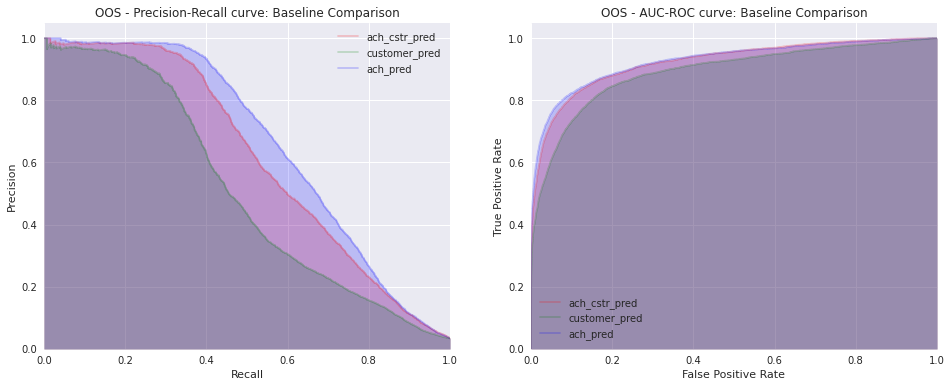

In [19]:
# OOS best predictions
fig, axs = plt.subplots(1, 2, figsize=(16,6))

preds = [(modeling_df[pred_col], pred_col), 
         (modeling_df['customer_pred'], 'customer_pred'),
         (modeling_df['pred'], 'ach_pred')
        ]

title = 'OOS - Precision-Recall curve: Baseline Comparison'
plot_pr_curve_mult(modeling_df[target_col], preds,
                   title=title, colors = ['r', 'g', 'b'], 
                   ax=axs[0], fig=fig) 

title = 'OOS - AUC-ROC curve: Baseline Comparison'
plot_auc_curve_mult(modeling_df[target_col], preds,
                   title=title, colors = ['r', 'g', 'b'], 
                   ax=axs[1], fig=fig)
plt.show()

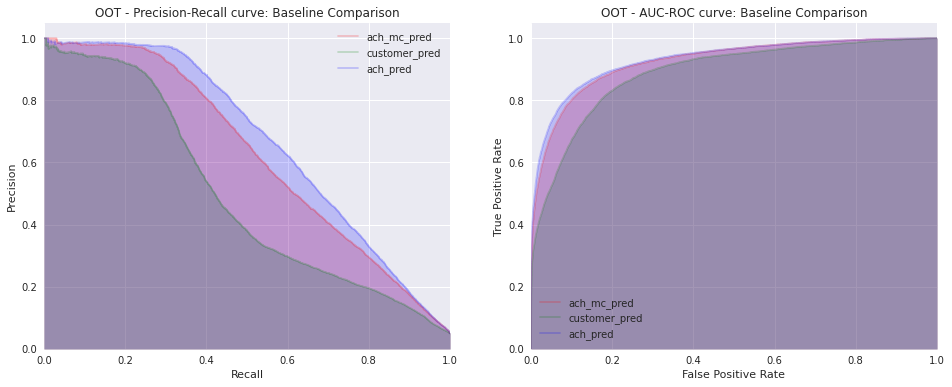

In [20]:
# OOT best predictions
fig, axs = plt.subplots(1, 2, figsize=(16,6))

preds = [(test_df[pred_col], 'ach_mc_pred'), 
         (test_df['customer_pred'], 'customer_pred'),
         (test_df['pred'], 'ach_pred')
        ]

title = 'OOT - Precision-Recall curve: Baseline Comparison'
plot_pr_curve_mult(test_df[target_col], preds,
                   title=title, colors = ['r', 'g', 'b'], 
                   ax=axs[0], fig=fig) 

title = 'OOT - AUC-ROC curve: Baseline Comparison'
plot_auc_curve_mult(test_df[target_col], preds,
                   title=title, colors = ['r', 'g', 'b'], 
                   ax=axs[1], fig=fig)
plt.show()

#### SHAP

In [21]:
import math
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

def get_shap_dependence(df, shap_values, features, ncols=6, figsize=None, **kwargs):
    """
    Build the partial dependence plot for a set of models and features.
    """
    nrows = math.ceil(len(features) / ncols)

    if figsize is None:
        figsize = (ncols * 6, nrows * 6)

    fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)
    for feature, ax in zip(features, axs.flatten()):
        shap.dependence_plot(feature, shap_values, df, 
                             ax=ax, show=False, **kwargs)
        rlim = df[feature].quantile(0.98)
        llim = df[feature].quantile(0.02) - ((rlim - df[feature].quantile(0.02)) / 12)
            
        if rlim < np.inf and llim > -np.inf:
            ax.set_xlim(left=llim, right=rlim)
        
    return fig

In [22]:
fimp = sorted(zip(final_model.feature_importances_, 
                  final_model.feature_name_), reverse=True)
features_by_imp = list(list(zip(*fimp))[1])

In [23]:
import shap

shap.initjs()
explainer = shap.TreeExplainer(final_model)
shap_values = explainer.shap_values(modeling_df[final_model.feature_name_])

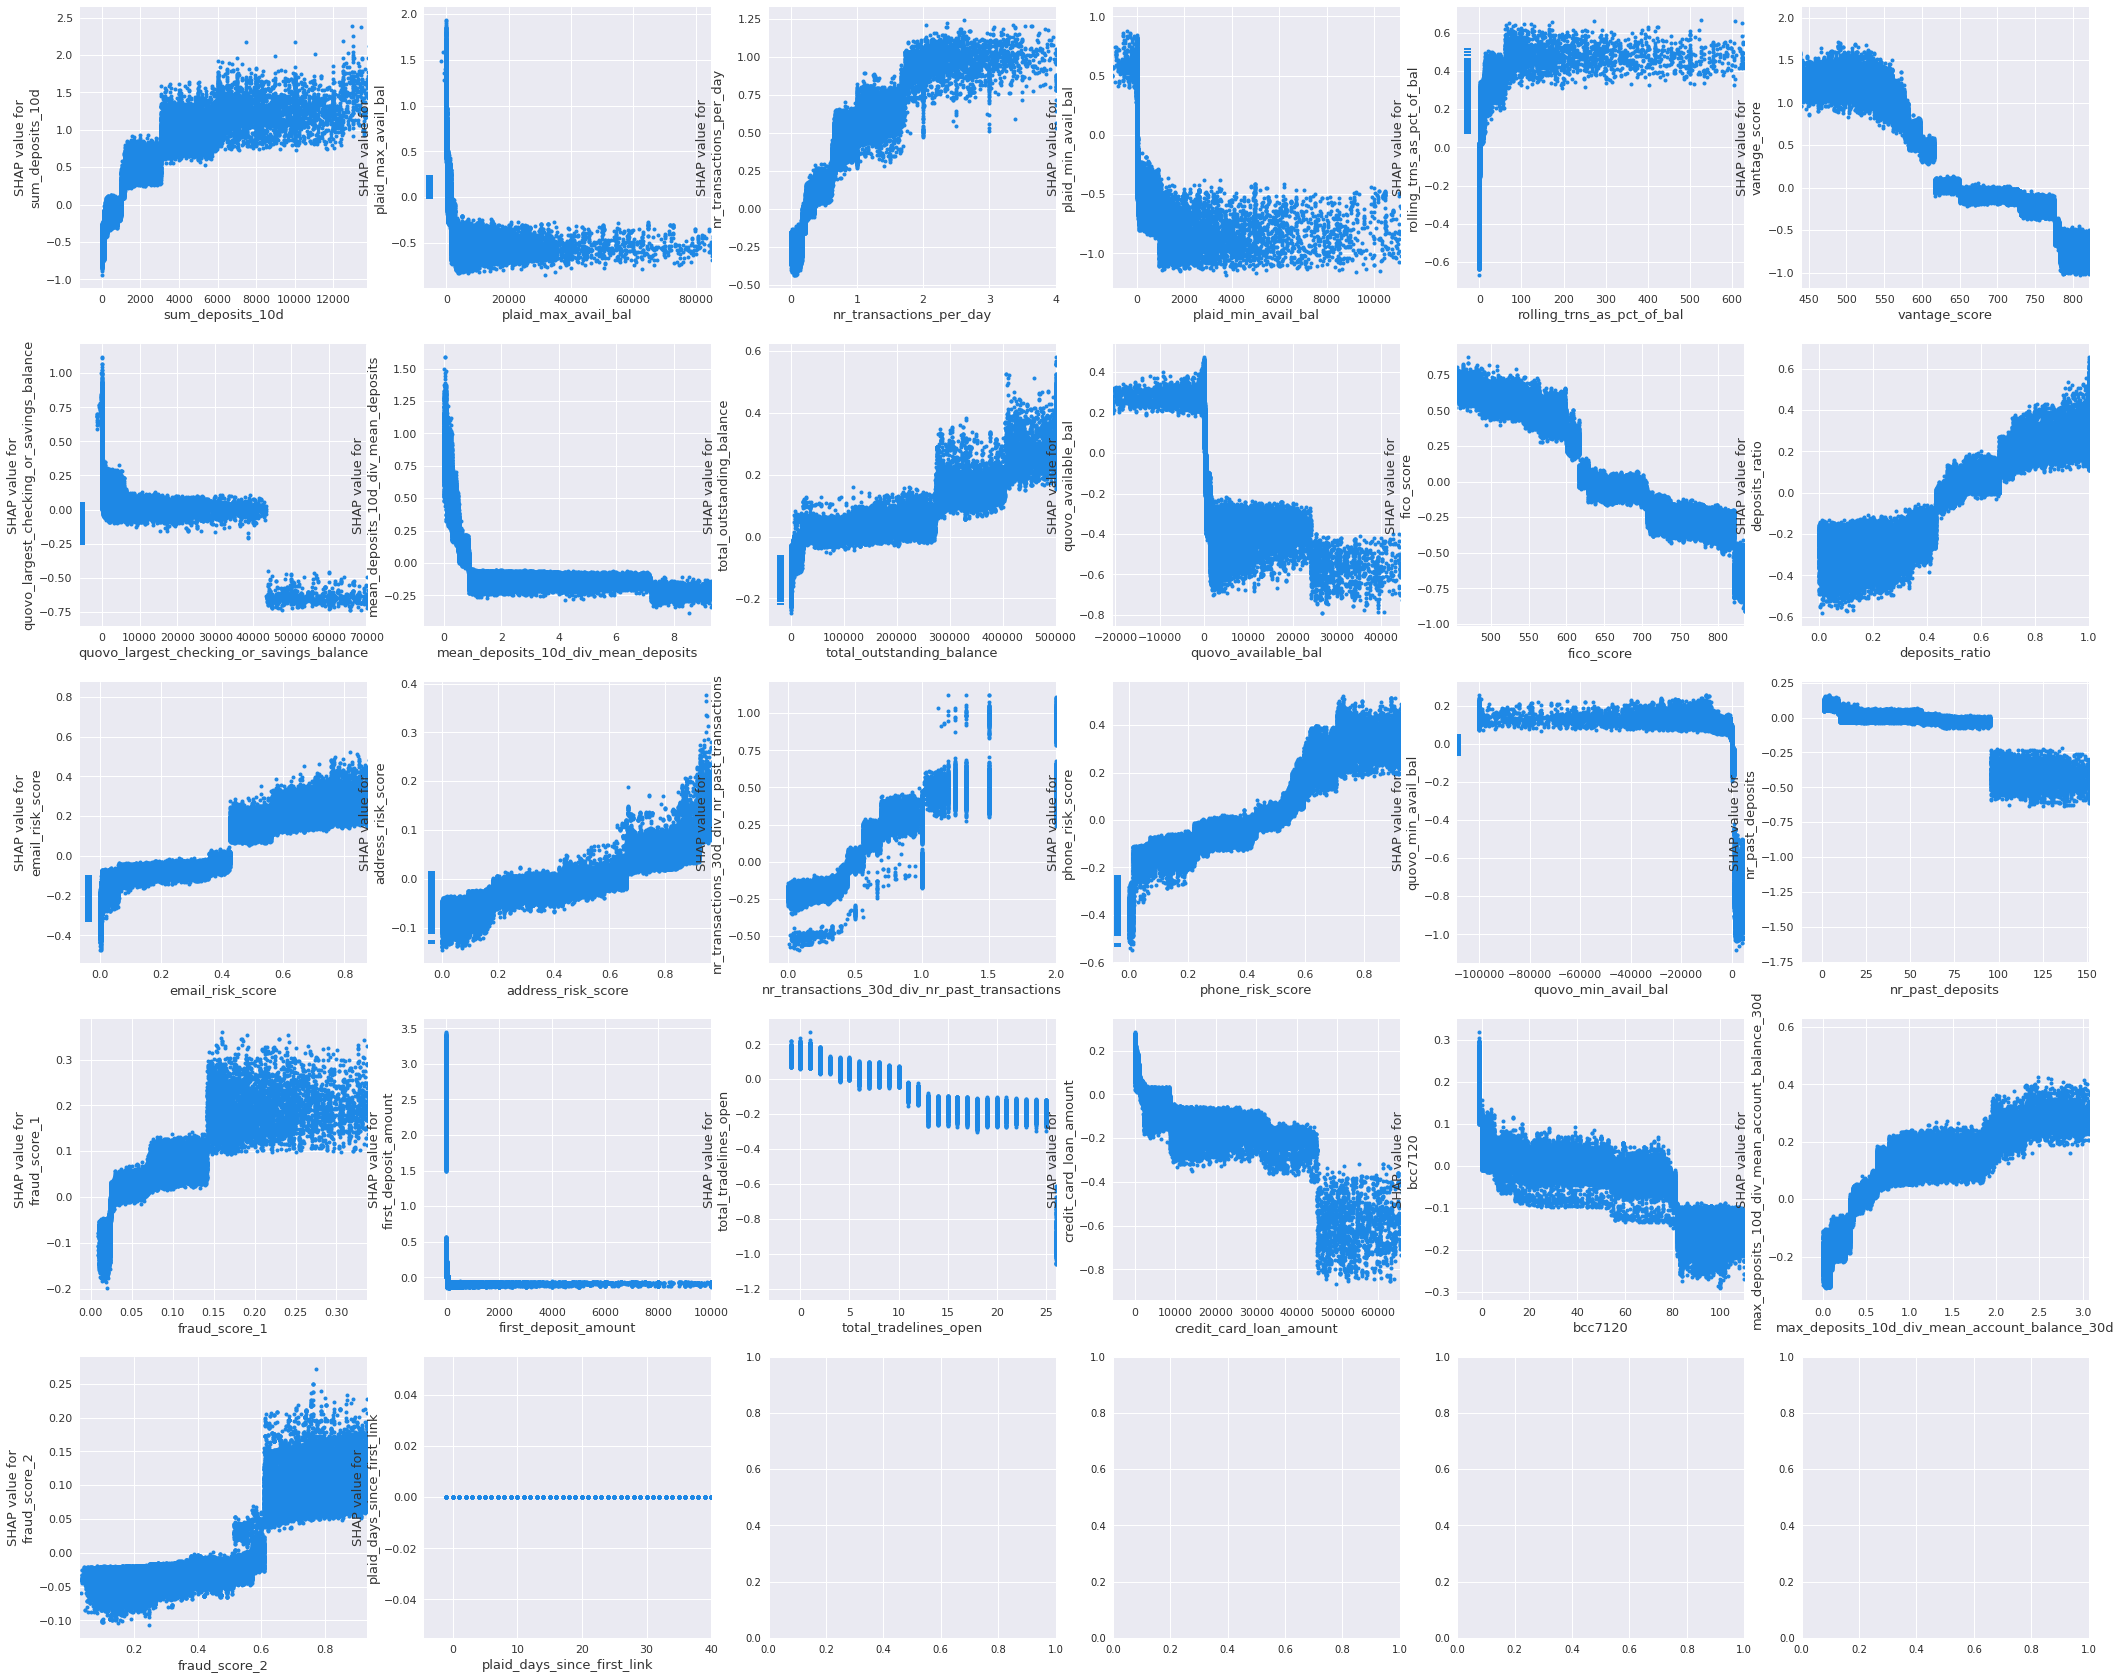

In [24]:
fig = get_shap_dependence(modeling_df[final_model.feature_name_], 
                          shap_values[1], features_by_imp, 
                          interaction_index=None)

In [ ]:
fig = get_shap_dependence(modeling_df[final_model.feature_name_], 
                          shap_values[1], features_by_imp[:18], 
                          interaction_index=None)